# BSDE Paper Summary



Let
\begin{align*}
u(t, S_t) = e^{-r(T-t)}\widetilde E[(S_T - K)^+|\mathcal F_t]
\end{align*}
be the NPV of a call option at time $t$. Under the Black-Scholes model, Ito lemma gives
\begin{align*}
du &= \left(u_t + rSU_S + \frac{\sigma^2S^2}{2}U_{SS}\right)\,dt + \sigma S U_S\,d\widetilde W_t\\
&= ru \,dt + \sigma S U_S\,d\widetilde W_t,
\end{align*}
where the last equation holds because $u$ must satisfy the Black-Scholes PDE
\begin{align*}
u_t + rSu_S + \frac{\sigma^2S^2}{2}u_{SS} = ru.
\end{align*}
Now discretize the $u$ process:
\begin{align*}
u(t_{n+1}, S_{t_{n+1}}) &= u(t_{n}, S_{t_{n}}) + ru(t_{n}, S_{t_{n}}) \Delta t + \sigma S_{t_n}u_S(t_{n}, S_{t_{n}}) \Delta W_n\\
&= (1+r\Delta t)u(t_{n}, S_{t_{n}}) + \sigma S_{t_n}u_S(t_{n}, S_{t_{n}}) \Delta W_n.
\end{align*}
We generate Monte Carlo simulation paths of $S_t$ and use them as training data to learn the function $u_S$ at each time step $t_n$. We train the neural network to minimize the error between $u(T, S_T)$ and the option's payoff function $(S_T - K)^+$.

In [ ]:
import math, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# MLP
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=64):
        super().__init__()
        # Input Layer
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        # Hidden Layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output Layer
        self.fc3 = nn.Linear(hidden_dim, 1)
        # Layer Batch Normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        # Relu Activation Function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Deep BSDE class
class DeepBSDE_BS(nn.Module):
    def __init__(self, S_min, S_max, r, sigma, K, dt, N, hidden_dim, device):
        super().__init__()
        self.device = device
        # Variable Initialization
        self.r = torch.as_tensor(r, device=device)
        self.sigma = torch.as_tensor(sigma, device=self.device)
        self.K = torch.as_tensor(K, device=self.device)
        self.S_max = torch.as_tensor(S_max, device=self.device)
        self.S_min = torch.as_tensor(S_min, device=self.device)
        self.dt = dt
        self.N = N
        # MLP for option price at t = 0 as a function of initial stock price
        self.u0_net = MLP(in_dim=1, hidden_dim=hidden_dim).to(device)
        # Construct a chain of MLP at each time step to predict delta
        self.du0_net = MLP(in_dim=1, hidden_dim=hidden_dim).to(device)
        self.nets = nn.ModuleList([MLP(1, hidden_dim).to(device) for _ in range(N - 1)])


    def forward(self, dW_seq):
        # Read in the brownian motion variable for each time step
        batch = dW_seq.size(0)
        # Initialize a random initial stock price S0
        S_n = self.S_min + torch.rand(batch, 1, device=self.device) * (self.S_max - self.S_min)
        # Define the option price at t = 0 as a function of S0
        Y = self.u0_net(S_n)
        # Predict the delta at t = 0
        delta_0 = self.du0_net(S_n)
        for n in range(self.N):
            # Get the Bronian motion variable for the current time step
            dW = dW_seq[:, n, :]
            # Preict the delta at current step
            delta = delta_0 if n == 0 else self.nets[n - 1](S_n)
            # Update stock price for the next time step
            S_next = S_n + self.r * S_n * self.dt + self.sigma * S_n * dW
            # Update the option face value for next time step
            Y = (1 + self.r * self.dt) * Y + self.sigma * S_n * delta * dW
            # Update S
            S_n = S_next
        # Calculate the payoff of MC path
        payoff = torch.relu(S_n - self.K)
        # Calculate the loss between simulated option value at t=T and calculate the loss
        # with terminal payoff
        term_loss = Y - payoff
        # return loss
        return term_loss

if __name__ == "__main__":
    #Initialize model parameters
    r, sigma, K = 0.05, 0.2, 100.0
    T, N = 1.0, 100
    S_max, S_min = 140, 60
    path_num = 1024
    hidden_dim = 64
    lr = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Discrete time step
    dt = T / N
    # Initialize an instance of BSDE model
    model = DeepBSDE_BS(S_min, S_max, r, sigma, K, dt, N, hidden_dim, device).to(device)
    # Using MSE loss
    criterion = nn.MSELoss()
    # Use Adam optimizer to update the model
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # dW ~ N(0, dt)
    # dW = sqrt(dt) * Zn, where Zn ~ N(0, 1)
    sqrt_dt = math.sqrt(model.dt)
    start_time = time.time()
    # Epoch number
    epochs = 1500
    for epoch in range(epochs):
        # Generate Brownian Motion Variable
        dW = sqrt_dt * torch.randn(path_num, N, 1, device=device)
        # Set the gradient from previous epoch to 0, avoid accumulation
        optimizer.zero_grad()
        # Get the loss for current epoch
        diff = model(dW)
        # Using MSE loss calculate the gradient and update the model to minimize the loss
        loss = criterion(diff, torch.zeros_like(diff))
        loss.backward()
        optimizer.step()
        if epoch == 0 or epoch % 50 == 49:
            print(f"Epoch [{epoch + 1:4d}/{epochs}]  Loss: {loss.item():.4e}")
    # Print time and save the model to working directory
    print(f"\nFinished in {time.time() - start_time:.2f} s")
    torch.save(model.state_dict(), f"BSbsde_model_delta_{epochs}_{lr}_{path_num}.pth")


Epoch [   1/1500]  Loss: 1.1393e+03
Epoch [  50/1500]  Loss: 3.1494e+02
Epoch [ 100/1500]  Loss: 2.3508e+02
Epoch [ 150/1500]  Loss: 1.5715e+02
Epoch [ 200/1500]  Loss: 7.7906e+01
Epoch [ 250/1500]  Loss: 3.5846e+01
Epoch [ 300/1500]  Loss: 1.3307e+01
Epoch [ 350/1500]  Loss: 6.0250e+00
Epoch [ 400/1500]  Loss: 3.2268e+00
Epoch [ 450/1500]  Loss: 8.2555e-01
Epoch [ 500/1500]  Loss: 8.0897e-01
Epoch [ 550/1500]  Loss: 1.1770e+00
Epoch [ 600/1500]  Loss: 7.8413e-01
Epoch [ 650/1500]  Loss: 6.7639e-01
Epoch [ 700/1500]  Loss: 7.1064e-01
Epoch [ 750/1500]  Loss: 9.3367e-01
Epoch [ 800/1500]  Loss: 7.0401e-01
Epoch [ 850/1500]  Loss: 9.6074e-01
Epoch [ 900/1500]  Loss: 8.5967e-01
Epoch [ 950/1500]  Loss: 5.8839e-01
Epoch [1000/1500]  Loss: 1.1446e+00
Epoch [1050/1500]  Loss: 8.1898e-01
Epoch [1100/1500]  Loss: 5.5023e-01
Epoch [1150/1500]  Loss: 6.0026e-01
Epoch [1200/1500]  Loss: 7.3913e-01
Epoch [1250/1500]  Loss: 9.2928e-01
Epoch [1300/1500]  Loss: 2.1074e+00
Epoch [1350/1500]  Loss: 1.7

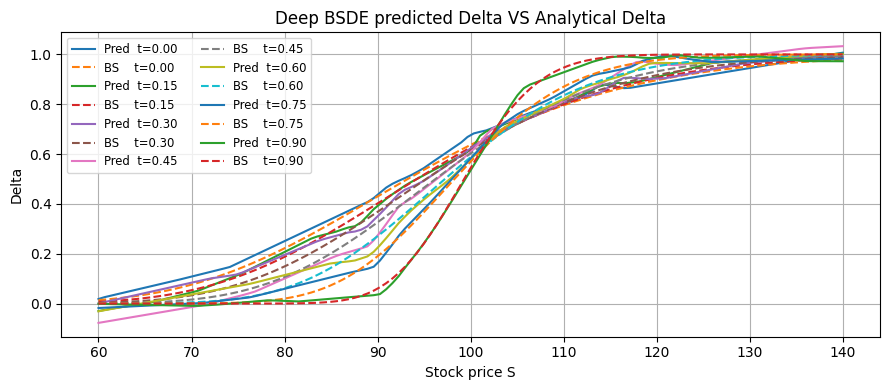

In [ ]:
import math, torch, numpy as np, matplotlib.pyplot as plt
from torch.distributions import Normal
import os, re

# Read in the trained model and initialize the model parameter
MODEL_PATH = "BSbsde_model_delta_1500_0.001_1024.pth"
r, sigma, K = 0.05, 0.2, 100.0
T, N            = 1.0, 100
S_max, S_min = 140, 60
hidden_dim      = 64
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

time_idx  = [0, 15, 30, 45, 60, 75, 90]
S_grid    = torch.linspace(60, 140, 120).view(-1, 1).to(device)
# Calculate the Analytical BS Delta
def bs_delta_np(S_np, K, T, t, r, sigma):
    tau = np.maximum(T - t, 1e-12)
    d1  = (np.log(S_np / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return Normal(0, 1).cdf(torch.tensor(d1)).numpy()
# Reconstruct the Deep BSDE Class
class MLP(torch.nn.Module):
    def __init__(self, in_dim=1, hidden_dim=64):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)
        self.bn1, self.bn2 = torch.nn.BatchNorm1d(hidden_dim), torch.nn.BatchNorm1d(hidden_dim)
        self.act = torch.nn.ReLU()
    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.act(self.bn2(self.fc2(x)))
        return self.fc3(x)

class DeepBSDE_BS(torch.nn.Module):
    def __init__(self, S_max, S_min, r, sigma, K, T, N, hidden_dim, device):
        super().__init__()
        self.device = device
        self.r, self.sigma, self.K = r, sigma, K
        self.dt   = T / N
        self.u0_net  = MLP(1, hidden_dim).to(device)
        self.du0_net = MLP(1, hidden_dim).to(device)
        self.nets    = torch.nn.ModuleList([MLP(1, hidden_dim).to(device) for _ in range(N - 1)])
# Initialize an instance
net = DeepBSDE_BS(S_max, S_min, r, sigma, K, T, N, hidden_dim, device).to(device)
# Load the trained Model's parameters
state = torch.load(MODEL_PATH, map_location=device)
net.load_state_dict(state)
# Initialize the model
net.eval()
# Plot the comparison between model prediction and the analytical solution
plt.figure(figsize=(9, 4))
for idx in time_idx:
    t     = idx * (T / N)
    S_np  = S_grid.squeeze().cpu().numpy()
    delta_bs = bs_delta_np(S_np, K, T, t, r, sigma)
    with torch.no_grad():
        if idx == 0:
            delta_pred = net.du0_net(S_grid).squeeze().cpu().numpy()
        else:
            delta_pred = net.nets[idx - 1](S_grid).squeeze().cpu().numpy()
    plt.plot(S_np, delta_pred,  "-",  label=f"Pred  t={t:.2f}")
    plt.plot(S_np, delta_bs,    "--", label=f"BS    t={t:.2f}")

plt.xlabel("Stock price S")
plt.ylabel("Delta")
plt.title(f"Deep BSDE predicted Delta VS Analytical Delta")
plt.grid(True)
plt.legend(fontsize="small", ncol=2)
plt.tight_layout()
plt.show()


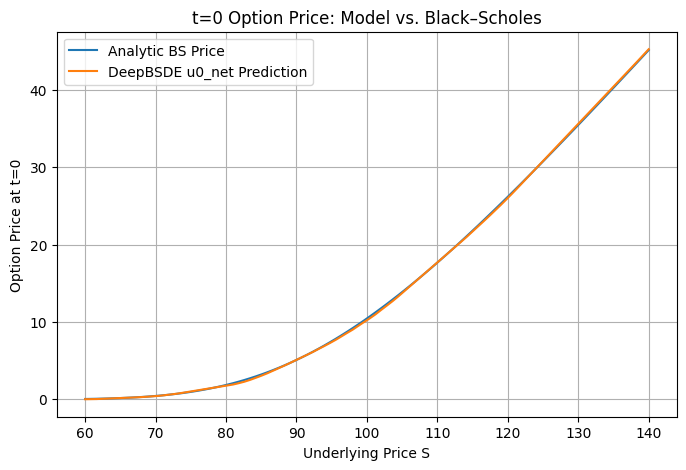

In [ ]:
import math, torch, numpy as np, matplotlib.pyplot as plt
from torch.distributions import Normal
import torch.nn as nn
# BS Call option price analytical solution
def bs_call_price(S, K, T, r, sigma):
    dtype = S.dtype
    device = S.device
    T_t = torch.tensor(T, dtype=dtype, device=device)
    r_t = torch.tensor(r, dtype=dtype, device=device)
    sigma_t = torch.tensor(sigma, dtype=dtype, device=device)

    sqrtT = torch.sqrt(T_t)
    d1 = (torch.log(S / K) + (r_t + 0.5 * sigma_t**2) * T_t) / (sigma_t * sqrtT)
    d2 = d1 - sigma_t * sqrtT
    N = Normal(0.0, 1.0)
    return S * N.cdf(d1) - K * torch.exp(-r_t * T_t) * N.cdf(d2)


# We will only use u0 net for option price
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

# Parameters
r, sigma, K = 0.05, 0.2, 100.0
T, N = 1.0, 100
S_max, S_min = 140.0, 60.0
hidden_dim = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Only use u0 MLP
u0_net = MLP(in_dim=1, hidden_dim=hidden_dim).to(device)
state = torch.load("BSbsde_model_delta_1500_0.001_1024.pth", map_location=device)
# Load the parameters for u0
u0_state = {k[len("u0_net."):]: v for k, v in state.items() if k.startswith("u0_net.")}
u0_net.load_state_dict(u0_state)

# predict at t = 0
n_S = 100
S_vals = torch.linspace(S_min, S_max, n_S, device=device).unsqueeze(1)
with torch.no_grad():
    price_pred = u0_net(S_vals).cpu().numpy().flatten()

# analytical solution
price_true = bs_call_price(S_vals, K, T, r, sigma).cpu().numpy().flatten()
S_np = S_vals.cpu().numpy().flatten()

# plot
plt.figure(figsize=(8,5))
plt.plot(S_np, price_true, label="Analytic BS Price")
plt.plot(S_np, price_pred, label="DeepBSDE u0_net Prediction")
plt.xlabel("Underlying Price S")
plt.ylabel("Option Price at t=0")
plt.title("t=0 Option Price: Model vs. Black–Scholes")
plt.legend()
plt.grid(True)
plt.show()
